In this notebook, CNN estimator is used as a regressor model.
This choice is leaded by the fact that :

<pre>
<li>NN model are non-linear models, then it is supposed to capture non-linear relations in between features </li>
<li>CNN model provides results while extracting semantic structures from text.</li>
</pre>

Multiple dataset are used in order to benchmark assumptions forged about model.

Data used for feeding model are read from mass storage.

Transformations that may occure over data are used only for the purpose of this notebooK.

In [5]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="CNN Regressor")

# <font color=blus>0. Notebook configuration</font>

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import time
import tensorflow as tf
import pandas as pd
import gensim


import p8_util
import p8_util_config
import p9_util
extension='_part'

OUTPUT_DIR = './tmp/baseline'
OUTPUT_DIR_TB = './tmp'
is_tensorboard = False



W0911 14:36:51.650804 140273291355968 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0911 14:36:51.651645 140273291355968 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/adanet/tf_compat/__init__.py:96: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.

Using TensorFlow backend.
W0911 14:36:51.948183 140273291355968 deprecation_wrapper.py:119] From /home/bangui/Dropbox/Perso/Formation/openclassrooms/OC_Datascientist/Kaggle/p8_util_config.py:137: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



#### Tensorboard processes are killed

In [2]:
# this will kill the processes for Tensorboard
#is_tensorboard = True
if is_tensorboard is True :
    !ps aux | grep tensorboard | awk '{print $2}' | xargs kill
# this will kill the processes for ngrok
if is_tensorboard is True :
    !ps aux | grep ngrok | awk '{print $2}' | xargs kill    

    Display an item from tokenized corpus

# <font color=blus>CNN Regressor</font>

In [3]:
import p9_util_config
dir(p9_util_config)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dict_param_generator',
 'dict_param_keras',
 'dict_param_keras_cnn',
 'dict_param_keras_rnn']

## <font color=blus>Building DataGenerator objects for CNN </font>

In [23]:
p9_util_config.dict_param_generator

{'data_type': 'valid',
 'partition_size': 800,
 'is_dimension_mux': True,
 'proj_dimension': None,
 'batch_size': 100,
 'n_classes': 0,
 'n_channels': 0,
 'is_shuffle': False,
 'keras_nb_channel': 34,
 'list_keras_channel': [0],
 'keras_input_dim': (80, 1)}

In [25]:
!rm ./data/train_X_*.*
!rm ./data/valid_X_*.*
import p9_util
import p9_util_config
import test_datapreparator

#----------------------------------------------------------------------------
# Common parameters for DataGenerator objects.
#----------------------------------------------------------------------------
dict_param_generator = p9_util_config.dict_param_generator
var_percent = 0.6


#----------------------------------------------------------------------------
# DataGenerator for train dataset
#----------------------------------------------------------------------------
dict_param_generator['partition_size'] = 1000
dict_param_generator['batch_size'] = 500
dict_param_generator['data_type'] = "train"
dict_param_generator['is_dimension_mux'] = True
keras_nb_channel = dict_param_generator['keras_nb_channel']
dict_param_generator['list_keras_channel'] = [channel for channel in range(keras_nb_channel)]

dict_rnn_preprocess={
    'filename_datapreparator' : './data/DataPreparator_train_v2_spacy_notfidf_20000.dill',\
    'var_percent' : var_percent,\
}
train_generator = test_datapreparator.build_rnn_datagenerator(**dict_rnn_preprocess)

#----------------------------------------------------------------------------
# DataGenerator for validation dataset
#----------------------------------------------------------------------------
dict_param_generator['partition_size'] = 800
dict_param_generator['batch_size'] = 100
dict_param_generator['data_type'] = "valid"
dict_param_generator['is_dimension_mux'] = True

dict_rnn_preprocess={
    'filename_datapreparator' : './data/DataPreparator_v2_spacy_valid_1000.dill',\
    'var_percent' : var_percent,\
}
valid_generator = test_datapreparator.build_rnn_datagenerator(**dict_rnn_preprocess)

p5_util.object_load : fileName= ./data/DataPreparator_train_v2_spacy_notfidf_20000.dill

DataPreparator Dataframe shape= (17366, 5)

Components= 34 for variance= 60.0%

data_type : train
partition_size : 1000
is_dimension_mux : True
proj_dimension : None
batch_size : 500
n_classes : 0
n_channels : 0
is_shuffle : False
keras_nb_channel : 34
list_keras_channel : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
keras_input_dim : (80, 1)
Building train partition...

p5_util.object_load : fileName= ./data/DataPreparator_v2_spacy_valid_1000.dill

DataPreparator Dataframe shape= (860, 5)

Components= 34 for variance= 60.0%

data_type : valid
partition_size : 800
is_dimension_mux : True
proj_dimension : None
batch_size : 100
n_classes : 0
n_channels : 0
is_shuffle : False
keras_nb_channel : 34
list_keras_channel : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2

In [6]:
valid_generator.proj_dimension

In [7]:
dict_param_train_generator = train_generator.get_params()
dict_param_train_generator

{'keras_input_dim': (80, 1),
 'batch_size': 500,
 'n_classes': 0,
 'n_channels': 0,
 'is_shuffle': False,
 'keras_nb_channel': 34,
 'list_keras_channel': [0],
 'data_type': 'train',
 'proj_dimension': None,
 'is_dimension_mux': True}

In [8]:
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (None, None),
  'batch_size': 5000,
  'nb_epoch': 15,
  'verbose': 1,
  'dropout_rate': 0.0,
  'is_batch_normalized': True,
  'lr': 0.0005,
  'nbClasses': 1},
 'filter_size': 1,
 'stride_size': 1,
 'pool_size': 0,
 'nb_filter': 256,
 'conv_layer': 1,
 'nb_dense_neuron': 8,
 'dense_layer': 4,
 'list_channel': []}

## <font color=blus>Configuration of CNN architecture</font>

    Update of CNN parameters for configuration.
    
    Generic parameters, are those parameters that apply to any kind of Keras architectures.
    
    Generic parameters are stored into dict_param_keras dictionary.
    
    Some of them depend from DataGenerator parameters such as : 
        * shape of input
        * batch size
    
    Other generic parameters values are hard-coded, such as : 
        * number of epoch for learning step;
        * dropout rate
        * verbocity
        * batch normalization
        * learning rate
        
    Specific parameters, are those parameters used to define CNN architecture.
    
    They are specific to architecture are also hard-coded here-under.
    

In [9]:
#---------------------------------------------------------------
# Update of generic paramaters depending of DataGenerator 
#---------------------------------------------------------------

dict_param_keras = p9_util_config.dict_param_keras_cnn['dict_param_keras'].copy()
dict_param_keras['input_dim'] = train_generator.get_params()['keras_input_dim']
dict_param_keras['batch_size'] = train_generator.get_params()['batch_size']

#---------------------------------------------------------------
# Update of specific paramaters depending of DataGenerator 
#---------------------------------------------------------------
p9_util_config.dict_param_keras_cnn['nb_channel'] = dict_param_train_generator['keras_nb_channel']

#---------------------------------------------------------------
# Update of other specific paramater
#---------------------------------------------------------------
p9_util_config.dict_param_keras_cnn['filter_size'] = 3
p9_util_config.dict_param_keras_cnn['stride_size'] = 2
p9_util_config.dict_param_keras_cnn['pool_size'] = 1
p9_util_config.dict_param_keras_cnn['nb_filter'] = 128
p9_util_config.dict_param_keras_cnn['list_channel'] = [5]*p9_util_config.dict_param_keras_cnn['nb_channel']
p9_util_config.dict_param_keras_cnn['dict_param_keras'] = dict_param_keras.copy()
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (80, 1),
  'batch_size': 500,
  'nb_epoch': 15,
  'verbose': 1,
  'dropout_rate': 0.0,
  'is_batch_normalized': True,
  'lr': 0.0005,
  'nbClasses': 1},
 'filter_size': 3,
 'stride_size': 2,
 'pool_size': 1,
 'nb_filter': 128,
 'conv_layer': 1,
 'nb_dense_neuron': 8,
 'dense_layer': 4,
 'list_channel': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 'nb_channel': 34}

In [10]:

#---------------------------------------------------------------
# Update of other specific paramater
#---------------------------------------------------------------

print("Batch size= {}".format(p9_util_config.dict_param_keras_cnn['dict_param_keras']['batch_size']))   

filter_size = p9_util_config.dict_param_keras_cnn['filter_size']
stride_size = p9_util_config.dict_param_keras_cnn['stride_size']

print("")
input_dim = p9_util_config.dict_param_keras_cnn['dict_param_keras']['input_dim']
for head_id in range(p9_util_config.dict_param_keras_cnn['nb_channel'] ) :
    if 0 < len(p9_util_config.dict_param_keras_cnn['list_channel']):
        filter_size = p9_util_config.dict_param_keras_cnn['list_channel'][head_id]
    else :
        filter_size = p9_util_config.dict_param_keras_cnn['filter_size']
        
    print("Expected defaut dimension for 1st hidden layer : {} Channel : {}".\
          format(round((input_dim[0]-filter_size+2*0)/stride_size +1), head_id))

print("")
for key, value in p9_util_config.dict_param_keras_cnn.items():
    if isinstance(value, dict) :
        for key2, value2 in value.items():
            print("--> {} : {}".format(key2, value2))
        print("")
    else :
        print("-> {} : {}".format(key, value))

Batch size= 500

Expected defaut dimension for 1st hidden layer : 38 Channel : 0
Expected defaut dimension for 1st hidden layer : 38 Channel : 1
Expected defaut dimension for 1st hidden layer : 38 Channel : 2
Expected defaut dimension for 1st hidden layer : 38 Channel : 3
Expected defaut dimension for 1st hidden layer : 38 Channel : 4
Expected defaut dimension for 1st hidden layer : 38 Channel : 5
Expected defaut dimension for 1st hidden layer : 38 Channel : 6
Expected defaut dimension for 1st hidden layer : 38 Channel : 7
Expected defaut dimension for 1st hidden layer : 38 Channel : 8
Expected defaut dimension for 1st hidden layer : 38 Channel : 9
Expected defaut dimension for 1st hidden layer : 38 Channel : 10
Expected defaut dimension for 1st hidden layer : 38 Channel : 11
Expected defaut dimension for 1st hidden layer : 38 Channel : 12
Expected defaut dimension for 1st hidden layer : 38 Channel : 13
Expected defaut dimension for 1st hidden layer : 38 Channel : 14
Expected defaut di

In [15]:
del(p9_util_config.dict_param_keras_cnn['nb_channel'])

In [16]:
p9_util_config.dict_param_keras_cnn

{'dict_param_keras': {'input_dim': (80, 1),
  'batch_size': 500,
  'nb_epoch': 15,
  'verbose': 1,
  'dropout_rate': 0.0,
  'is_batch_normalized': True,
  'lr': 0.0005,
  'nbClasses': 1},
 'filter_size': 3,
 'stride_size': 2,
 'pool_size': 1,
 'nb_filter': 128,
 'conv_layer': 1,
 'nb_dense_neuron': 8,
 'dense_layer': 4,
 'list_channel': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5]}

In [17]:
import p9_util_keras
model = p9_util_keras.keras_cnn_channel_build(**p9_util_config.dict_param_keras_cnn)
if model is not None :
    model.summary()

W0911 14:40:01.575434 140273291355968 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0911 14:40:01.576558 140273291355968 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 14:40:01.627891 140273291355968 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0911 14:40:01.640301 140273291355968 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 80, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 80, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 80, 1)        0                                            
__________________________________________________________________________________________________
input_5 (I

In [18]:
p9_util_config.dict_param_keras_cnn['dict_param_keras']

{'input_dim': (80, 1),
 'batch_size': 500,
 'nb_epoch': 15,
 'verbose': 1,
 'dropout_rate': 0.0,
 'is_batch_normalized': True,
 'lr': 0.0005,
 'nbClasses': 1}

In [26]:
# Train model on dataset
epochs = p9_util_config.dict_param_keras_cnn['dict_param_keras']['nb_epoch']
verbose = p9_util_config.dict_param_keras_cnn['dict_param_keras']['verbose']

history = model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=verbose, epochs=epochs)

Epoch 1/15
35/35 [==============================] - 90s 3s/step - loss: 0.5075 - mean_absolute_error: 0.5884 - val_loss: 0.2571 - val_mean_absolute_error: 0.4366
Epoch 2/15
35/35 [==============================] - 69s 2s/step - loss: 0.2100 - mean_absolute_error: 0.3951 - val_loss: 0.1940 - val_mean_absolute_error: 0.3873
Epoch 3/15
35/35 [==============================] - 76s 2s/step - loss: 0.1162 - mean_absolute_error: 0.3038 - val_loss: 0.1134 - val_mean_absolute_error: 0.2976
Epoch 4/15
35/35 [==============================] - 76s 2s/step - loss: 0.0782 - mean_absolute_error: 0.2501 - val_loss: 0.0799 - val_mean_absolute_error: 0.2486
Epoch 5/15
23/35 [==================>...........] - ETA: 22s - loss: 0.0616 - mean_absolute_error: 0.2192

KeyboardInterrupt: 

In [22]:
x,y = train_generator[0]
x[0].shape, len(x)

((500, 80, 1), 1)

# <font color=blus>1. Loading dataset</font>

In [5]:
! ls -alrth ./data/DataPreparator_*.dump

-rw-r--r-- 1 bangui bangui 133M août  19 20:44 ./data/DataPreparator_train.dump
-rw-r--r-- 1 bangui bangui 134M août  19 20:44 ./data/DataPreparator_test.dump
-rw-r--r-- 1 bangui bangui 137M août  23 00:43 ./data/DataPreparator_train_spacy_20000.dump
-rw-r--r-- 1 bangui bangui 137M août  23 01:35 ./data/DataPreparator_test_spacy_20000.dump
-rw-r--r-- 1 bangui bangui 339M août  26 22:57 ./data/DataPreparator_train_spacy_15000.dump
-rw-r--r-- 1 bangui bangui 339M août  26 23:32 ./data/DataPreparator_test_spacy_15000.dump


In [3]:
n_sample = 15000

## <font color=blus>1.1. Loading train DataPreparator </font>

vocab_size = len(dataPreparator_train.kerasTokenizer.tokenizer.word_index) + 1
vocab_size

In [4]:
import numpy as np
import p5_util

filename_train = './data/DataPreparator_train_spacy_'+str(n_sample)+'.dump'

dataPreparator_train = p5_util.object_load(filename_train)
    
print("")
print("DataPretarator train lenth= {}".format(len(dataPreparator_train)))


vocab_size = len(dataPreparator_train.kerasTokenizer.tokenizer.word_index) + 1
print("Vocabulary size= {}".format(vocab_size))

X_train, y_train = dataPreparator_train.transform(None, None)

dataPreparator_train.df_data.sample()

p5_util.object_load : fileName= ./data/DataPreparator_train_spacy_15000.dump

DataPretarator train lenth= 13623
Vocabulary size= 1
transform : fit OK, Corpus vectorized!


,docs,tokens,counting,vector,target
9085,"jesus ..... he told his disciples , for instan...","[tell, disciple, instance, strong, man, fully,...",11,"[0.024025348524252574, -0.011519223848978678, ...",0.0


## <font color=blus>1.2. Loading test DataPreparator </font>

In [5]:
import numpy as np
import p5_util

#filename_test = './data/DataPreparator_test.dump'
filename_test = './data/DataPreparator_test_spacy_'+str(n_sample)+'.dump'

dataPreparator_test = p5_util.object_load(filename_test)
    
print("")
print("DataPretarator test lenth=  {}".format(len(dataPreparator_test)))

X_test = dataPreparator_test.X
y_test = dataPreparator_test.y
print(X_test.shape, y_test.shape)
dataPreparator_test.df_data.sample()


p5_util.object_load : fileName= ./data/DataPreparator_test_spacy_15000.dump

DataPretarator test lenth=  13616
(13616, 300) (13616,)


,docs,tokens,counting,vector,target
4382,"you got ta love people who pose a question , a...","[got, ta, love, people, pose, question, immedi...",22,"[-0.05078859607378642, 0.03211382697646817, -0...",0.0


    For validation, a 1/3 of train dataset observations is picked up from test dataset.

In [6]:
valid_sample = X_train.shape[0]//3
valid_sample
X_test = X_test[:valid_sample,:]
y_test = y_test[:valid_sample]
print("")
print("Sample of test dataset : X_test shape= {}, y_test shape= {}".format(X_test.shape, y_test.shape))


Sample of test dataset : X_test shape= (4541, 300), y_test shape= (4541,)


#### Dimension reduction

In [18]:
if False :
    X_dimension = 100
    X_train = X_train[:,:X_dimension]
    X_test  = X_test[:,:X_dimension]

In [19]:
#print(dataPreparator_train.df_data.columns)

#### Sentences tokens counts distribution

count    4593.000000
mean       27.991291
std        23.849611
min         4.000000
25%        10.000000
50%        20.000000
75%        39.000000
max       129.000000
Name: counting, dtype: float64
 
count    4581.000000
mean       27.840428
std        23.512100
min         4.000000
25%        10.000000
50%        20.000000
75%        38.000000
max       114.000000
Name: counting, dtype: float64


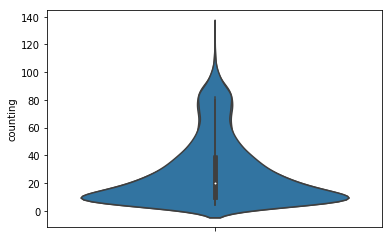

In [9]:
import seaborn as sns

df = dataPreparator_train.df_data['counting']
print(df.describe())
z_=sns.violinplot( y=df )

print(" ")
df = dataPreparator_test.df_data['counting']
print(dataPreparator_test.df_data['counting'].describe())
z_=sns.violinplot( y=df )

## <font color=blus>1.x. Dataset standardization </font>

In [20]:
print(X_train.shape, X_test.shape)

(13623, 300) (4541, 300)


In [21]:
import p9_util
import random
if False :
    scaler, X_train_std, X_test_std = p9_util.data_scale(X_train, X_test, scaler_name='Standard')

## <font color=blus>1.3. Building data generator for train and validation datasets</font>

In [7]:
embedding_dim=1
dimension = 0# Will be updated in function build_generators()
dict_param = {'dim': (dimension,embedding_dim),
              'batch_size': 100,
              'n_classes': 0,
              'n_channels': 1,
              'shuffle': False,
              'nb_channel':100,
             }
partition_size = 1000
print(dict_param)


!rm ./data/train_X_*.*
!rm ./data/test_X_*.*

import test_datapreparator
train_generator, test_generator = test_datapreparator.build_generators(dataPreparator_train, dataPreparator_test, partition_size,dict_param )
dict_param = train_generator.get_params()
dict_param

{'dim': (0, 1), 'batch_size': 100, 'n_classes': 0, 'n_channels': 1, 'shuffle': False, 'nb_channel': 100}
(13623, 300)
Building train partition...

Building test partition...one!



{'dim': (300, 1),
 'batch_size': 100,
 'n_classes': 0,
 'n_channels': 1,
 'shuffle': False,
 'nb_channel': 100}

# <font color=blus>2. CNN processing using Keras</font>

    Convolutional layers are built with strides >0.
    This is equivalent to process n-gram group of words.


## <font color=blus>2.1 Configuration of regression model</font>

## <font color=blus>2.2 Modeling a regression model</font>

Ouptput layer dimensions for convolutional network is computed as following : 

*  <code>C = [(I-F + 2*P)/S] +1</code> where :
    * <code>C</code> is the dimension of the ouput convolutional layer;
    * <code>I</code> is the input size
    * <code>F</code> is the convolutional filter size
    * <code>P</code> is the padding size (0 here)
    * <code>S</code> is the strides length
    

Strides value of <code>S</code> allows to regard a bulk of <code>S</code> consecutive words for sentences patterns exploration. 

For compilation, a learning rate of <code>0.01</code> increases the speed of learning. 

Batch normalization insures a smooth learning.

Batch size is selected in a such way an epoch is formed with 10 mini-batches.

In [8]:
filter_size = 3
stride_size = 2

print("Batch size= {}".format(dict_param['batch_size']))   



dict_cnn_param={'input_shape':dict_param['dim'],
                'nb_channel' : dict_param['nb_channel'],
               'nbClasses': 1,
               'stride_size':stride_size,
               'nb_filter':256,
               'lr': 1.e-2,
               'dropout_rate':0.0,
               'conv_layer':1,
               'nb_dense_neuron':64,
               'dense_layer':4,
               'pool_size':1,
               'list_channel':[5]*dict_param['nb_channel']}
print("")
for head_id in range(len(dict_cnn_param['list_channel'])) :
    filter_size = dict_cnn_param['list_channel'][head_id]
    print("Expected defaut dimension for 1st hidden layer : {}".format(round((dict_param['dim'][0]-filter_size+2*0)/stride_size +1)))

print("")
for key, value in dict_cnn_param.items():
    print("{} : {}".format(key, value))

Batch size= 100

Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for 1st hidden layer : 148
Expected defaut dimension for

In [9]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dense, Dropout, Embedding, Reshape, Input
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers.merge import concatenate


#-------------------------------------------------------------------------------
#
#-------------------------------------------------------------------------------    
def keras_cnn_build(input_shape=(0,0), nbClasses=1, stride_size=4\
                    ,nb_filter=64,filter_size=5,lr=1.e-2,\
                    isWordEmbedding=False, vocab_size = None,\
                    weight_matrix=None, is_dropout=False,\
                    dropout_rate=0.2, conv_layer=1, nb_dense_neuron=16,\
                    dense_layer=1, pool_size=2, nb_channel=1, \
                    list_channel=list()):
    '''Builds a convolutional model using keras framework.
    
    Input : 
        * input_shape : size of input for input layer.
        * nbClasses : number of classes for classication model.
            When nbClasses value is 1 then estimator is turned into a 
            regression model. Otherwise, estimatir is turned into a 
            classifier model.
    '''
    if input_shape == (0,0) :
        print("\n***ERROR : invalid input_shape parameter : {}".format(input_shape))
        return None
    
    isRegression=True
    if nbClasses > 1 :
        isRegression=False

    if isRegression :
        loss='mean_squared_error'
        metrics=['mae']
        activation = 'linear'
    else :
        loss='categorical_crossentropy'
        #metrics=['accuracy']
        metrics=['categorical_accuracy']
        
        activation = 'softmax'
    
    if dropout_rate is not None :
        if dropout_rate > 0. :
            is_dropout = True
        else :
            pass
    else :
        pass

    model = Sequential()
    
    if isWordEmbedding :
        #----------------------------------------------------------------
        # Embedding layer
        #----------------------------------------------------------------
        max_length = input_shape[0]
        embedding_dim = input_shape[1]
        model.add(keras.layers.Embedding(vocab_size, embedding_dim, \
        weights=[weight_matrix], input_length = max_length, trainable=False))
    else :
        #----------------------------------------------------------------
        # Convolutional layers
        #----------------------------------------------------------------
        if conv_layer > 0:
            filter_size = list_channel[0]
            for i in range(conv_layer) :
                #print("Conv layer id= {}".format(i))
                if 0 == i: 
                    #----------------------------------------------------
                    # For first conv layer then input shape is feeded
                    #----------------------------------------------------
                    model.add(BatchNormalization(input_shape=input_shape))
                    model.add(Conv1D(filters=nb_filter, \
                                     kernel_size=filter_size, \
                                     padding = 'same',\
                                     activation='relu',\
                                     strides=stride_size))
                else :
                    pass

                model.add(BatchNormalization())
                model.add(Conv1D(filters=nb_filter, \
                                 kernel_size=filter_size, \
                                 padding = 'same',\
                                 activation='relu',\
                                 strides=stride_size))
                #model.add(BatchNormalization())
                if pool_size > 0 :
                    model.add(MaxPooling1D(pool_size=pool_size))
                else :
                    pass

            #----------------------------------------------------------------
            # Flatten layer for connecting dense layers
            #----------------------------------------------------------------
            model.add(Flatten())
        else :
            pass    

    #---------------------------------------------------------------------------
    # Dense layers
    #---------------------------------------------------------------------------
    if conv_layer <= 0:
        #-----------------------------------------------------------------------
        # No convolutional layer : build input dense layer
        #-----------------------------------------------------------------------
        model.add(Dense(nb_dense_neuron, input_dim=input_shape[0]))
        
    for i in range(dense_layer) :
        #-----------------------------------------------------------------------
        # Dense layers are added
        #-----------------------------------------------------------------------
        model.add(BatchNormalization())
        model.add(Dense(nb_dense_neuron, activation='relu'))
        if is_dropout :
            model.add(Dropout(dropout_rate))
        #-----------------------------------------------------------------------
        # Number of neurons in next dene layer is decreased by 2
        #-----------------------------------------------------------------------
        nb_dense_neuron //= 2

    model.add(BatchNormalization())
    model.add(Dense(nbClasses, activation=activation))

    sgd = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    
    #plot_model(model, show_shapes=True, to_file='keras_cnn_build.png')

    model.compile(loss=loss, optimizer=sgd, metrics=metrics)


    return model
#-------------------------------------------------------------------------------    


In [10]:
dict_cnn_param

{'input_shape': (300, 1),
 'nb_channel': 100,
 'nbClasses': 1,
 'stride_size': 2,
 'nb_filter': 256,
 'lr': 0.01,
 'dropout_rate': 0.0,
 'conv_layer': 1,
 'nb_dense_neuron': 64,
 'dense_layer': 4,
 'pool_size': 1,
 'list_channel': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5]}

In [11]:
import p9_util
model = p9_util.keras_cnn_channel_build(**dict_cnn_param)
if model is not None :
    model.summary()

W0829 13:46:16.135893 139696318617408 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 13:46:16.152388 139696318617408 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 13:46:16.229803 139696318617408 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0829 13:46:16.254500 139696318617408 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 1)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 300, 1)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 300, 1)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 300, 1)       0                                            
__________________________________________________________________________________________________
input_5 (I

In [ ]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=1, epochs=10)

W0829 13:47:12.738855 139696318617408 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10


In [197]:
dict_cnn_param

{'input_shape': (300, 1),
 'nb_channel': 3,
 'nbClasses': 1,
 'stride_size': 2,
 'nb_filter': 256,
 'lr': 0.01,
 'dropout_rate': 0.0,
 'conv_layer': 0,
 'nb_dense_neuron': 64,
 'dense_layer': 4,
 'pool_size': 1,
 'list_channel': [5, 9, 11]}

In [198]:
import p9_util
model = keras_cnn_build(**dict_cnn_param)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 64)                19264     
_________________________________________________________________
batch_normalization_362 (Bat (None, 64)                256       
_________________________________________________________________
dense_271 (Dense)            (None, 64)                4160      
_________________________________________________________________
batch_normalization_363 (Bat (None, 64)                256       
_________________________________________________________________
dense_272 (Dense)            (None, 32)                2080      
_________________________________________________________________
batch_normalization_364 (Bat (None, 32)                128       
_________________________________________________________________
dense_273 (Dense)            (None, 16)                528       
__________

In [ ]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=1, epochs=10)

#### CNN model and history are either saved or restored depending a Boolean flag.

`core_name` is a parameter identifying a model through its name.

This name may be changed depending model parameters.

In [1]:
core_name = "cnn_6layers"

In [80]:
import keras
import p5_util

if True:
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    #p5_util.object_dump(max_length, "max_length_"+core_name+".dump")

In [2]:
import keras
import p5_util

if False :
    pass
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    #max_length = p5_util.object_load("max_length_"+core_name+".dump")

#print("\nInput data length= {}".format(max_length))
model.summary()

Using TensorFlow backend.
W0827 18:51:42.824997 140085555423040 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 18:51:42.839365 140085555423040 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 18:51:43.199454 140085555423040 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 18:51:43.200655 140085555423040 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: Th

p5_util.object_load : fileName= history_cnn_6layers.dump
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 300, 1)       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 300, 1)       0                                            
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 148, 128)     768         input_26[0][0]                   
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 145, 128)     1536        input_27[0][0]                   
____________________________________________________

In [3]:
history.history

{'val_loss': [483.6739419114576,
  0.43685562276969786,
  0.04430255075078348,
  0.03799221505379232,
  0.031340978663473816,
  0.03476240773620708,
  0.03370662399301728,
  0.12829227672646876,
  0.05169915286036149,
  0.08329047533009337],
 'val_mean_absolute_error': [15.409050887395857,
  0.3412119145521546,
  0.13845673030336442,
  0.12089749727043576,
  0.11513416267730095,
  0.1134102807482037,
  0.11273634060341799,
  0.1152601511700278,
  0.11590046272093275,
  0.10961075520884907],
 'loss': [0.09340383094655937,
  0.035766286322490015,
  0.033025283881359266,
  0.03131456958031695,
  0.030148836058517793,
  0.02914932604291484,
  0.028298167398336578,
  0.027486173683523275,
  0.02689516687742337,
  0.026474092812399406],
 'mean_absolute_error': [0.1773727047284129,
  0.13354061855900037,
  0.12637707659202044,
  0.12210228594990367,
  0.11950299746159948,
  0.11674749787128734,
  0.11446438282006272,
  0.11240162699539599,
  0.11131973189060396,
  0.11010014778505572]}

    Metric and loss curves are displayed for train and test dataset.

In [5]:
for key, values in history.history.items() :
    history.history[key] = values[1:]
history.history

{'val_loss': [0.04430255075078348,
  0.03799221505379232,
  0.031340978663473816,
  0.03476240773620708,
  0.03370662399301728,
  0.12829227672646876,
  0.05169915286036149,
  0.08329047533009337],
 'val_mean_absolute_error': [0.13845673030336442,
  0.12089749727043576,
  0.11513416267730095,
  0.1134102807482037,
  0.11273634060341799,
  0.1152601511700278,
  0.11590046272093275,
  0.10961075520884907],
 'loss': [0.033025283881359266,
  0.03131456958031695,
  0.030148836058517793,
  0.02914932604291484,
  0.028298167398336578,
  0.027486173683523275,
  0.02689516687742337,
  0.026474092812399406],
 'mean_absolute_error': [0.12637707659202044,
  0.12210228594990367,
  0.11950299746159948,
  0.11674749787128734,
  0.11446438282006272,
  0.11240162699539599,
  0.11131973189060396,
  0.11010014778505572]}

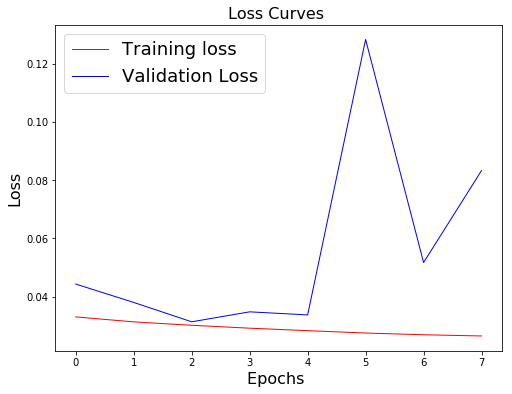

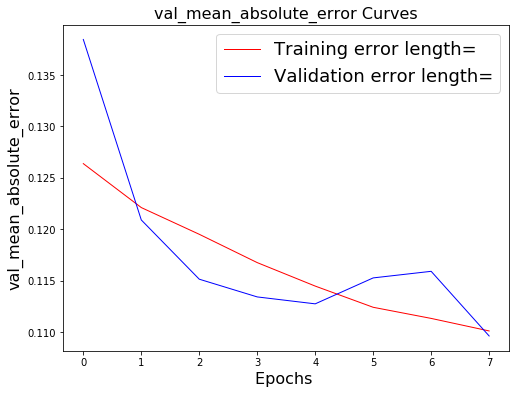

In [7]:
import p7_util
max_length=''
list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

## <font color=blus>2.3 Modeling a regression model with part of test dataset</font>

### <font color=blus>2.3.1 Building partial DataPreparator for validation </font>

In [29]:
params

{'dim': (300, 1),
 'batch_size': 100,
 'n_classes': 0,
 'n_channels': 1,
 'shuffle': False}

In [64]:
len(dataPreparator_test)
df_test_part = dataPreparator_test.df_data.sample(500)
df_test_part.shape
X_test = np.array(df_test_part.vector.tolist())
y_test = np.array(df_test_part.target.tolist())
X_test.shape, y_test.shape

((500, 300), (500,))

### <font color=blus>2.3.1 Making disks partitions </font>

In [65]:
X_train.shape,X_test.shape, 

((4571, 300), (500, 300))

In [66]:
!rm ./data/test_X_*.*
!rm ./data/train_X_*.*


In [67]:
import p9_util

partition_size = 1000
dict_train_partition, dict_train_label = p9_util.make_partition(X_train, \
                                            y_train, partition_size,\
                                            data_type="train", data_format='ndarray' )

Building train partition...



In [68]:
import p9_util
partition_size_part = 500
dict_test_partition, dict_test_label = p9_util.make_partition(X_test, \
                                              y_test,partition_size_part,\
                                              data_type="test", data_format='ndarray' )

Building test partition...



In [69]:
dict_test_partition.values()

dict_values(['./data/test_X_0.npy'])

### <font color=blus>1.3.2 Building train and valid `DataGenerator` </font>

In [70]:
import p9_util

embedding_dim=1
dimension = X_train.shape[1]
params = {'dim': (dimension,embedding_dim),
          'batch_size': 100,
          'n_classes': 0,
          'n_channels': 1,
          'shuffle': False}
print(params)

# Data Generators
import DataGenerator
len_train = X_train.shape[0]
train_generator = DataGenerator.DataGenerator(dict_train_partition, dict_train_label, partition_size, len_train,**params)

len_test = X_test.shape[0]
test_generator = DataGenerator.DataGenerator(dict_test_partition, dict_test_label, partition_size,len_test, **params)

{'dim': (300, 1), 'batch_size': 100, 'n_classes': 0, 'n_channels': 1, 'shuffle': False}


In [71]:
filter_size = 7
strides = filter_size-1

print("Expected defaut dimension for 1st hidden layer : {}".format(round((dimension-filter_size+2*0)/strides +1)))

Expected defaut dimension for 1st hidden layer : 50


Strides value of <code>S</code> allows to regard a bulk of <code>S</code> consecutive words for sentences patterns exploration. 

For compilation, a learning rate of <code>0.01</code> increases the speed of learning. 

Batch normalization insures a smooth learning.

Batch size is selected in a such way an epoch is formed with 10 mini-batches.

In [72]:
import p9_util
nb_channel=1
model = p9_util.keras_cnn_build((dimension, nb_channel),nbClasses=1, \
                                strides=strides, nb_filter=128, filter_size=strides, \
                                lr=1.e-2, is_dropout=True, dropout_rate=0.2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 128)           896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 128)           512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 128)            98432     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1152)              4608      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                18448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
__________

In [73]:
import numpy as np
x= np.load("./data/test_X_0.npy")
x[0].shape

(300,)

In [74]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=False,
                    workers=1, verbose=1, epochs=100)

Epoch 1/100
46/46 [==============================] - 3s 68ms/step - loss: 0.2547 - mean_absolute_error: 0.2752 - val_loss: 9.0563 - val_mean_absolute_error: 2.9982
Epoch 2/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0410 - mean_absolute_error: 0.1306 - val_loss: 0.8774 - val_mean_absolute_error: 0.9153
Epoch 3/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0371 - mean_absolute_error: 0.1238 - val_loss: 0.2166 - val_mean_absolute_error: 0.4229
Epoch 4/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0364 - mean_absolute_error: 0.1226 - val_loss: 0.0440 - val_mean_absolute_error: 0.1235
Epoch 5/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0349 - mean_absolute_error: 0.1195 - val_loss: 0.0433 - val_mean_absolute_error: 0.1185
Epoch 6/100
46/46 [==============================] - 1s 31ms/step - loss: 0.0341 - mean_absolute_error: 0.1168 - val_loss: 0.0423 - val_mean_absolute_error: 0.1141
Epoch 7/100
46/4

Epoch 51/100
46/46 [==============================] - 2s 34ms/step - loss: 0.0242 - mean_absolute_error: 0.0879 - val_loss: 0.0342 - val_mean_absolute_error: 0.1133
Epoch 52/100
46/46 [==============================] - 1s 32ms/step - loss: 0.0219 - mean_absolute_error: 0.0842 - val_loss: 0.0343 - val_mean_absolute_error: 0.1167
Epoch 53/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0234 - mean_absolute_error: 0.0866 - val_loss: 0.0346 - val_mean_absolute_error: 0.1152
Epoch 54/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0214 - mean_absolute_error: 0.0846 - val_loss: 0.0349 - val_mean_absolute_error: 0.1178
Epoch 55/100
46/46 [==============================] - 2s 35ms/step - loss: 0.0232 - mean_absolute_error: 0.0871 - val_loss: 0.0344 - val_mean_absolute_error: 0.1159
Epoch 56/100
46/46 [==============================] - 2s 33ms/step - loss: 0.0235 - mean_absolute_error: 0.0879 - val_loss: 0.0341 - val_mean_absolute_error: 0.1164
Epoch 57/1

#### CNN model and history are either saved or restored depending a Boolean flag.

`core_name` is a parameter identifying a model through its name.

This name may be changed depending model parameters.

In [1]:
core_name = "cnn_6layers"

In [75]:
import keras
import p5_util

if True:
    model.save("./data/model_"+core_name+".h5")
    p5_util.object_dump(history, "history_"+core_name+".dump")
    #p5_util.object_dump(max_length, "max_length_"+core_name+".dump")

In [2]:
import keras
import p5_util

if False :
    pass
else :
    model = keras.models.load_model("./data/model_"+core_name+".h5")
    history = p5_util.object_load("history_"+core_name+".dump")
    #max_length = p5_util.object_load("max_length_"+core_name+".dump")

#print("\nInput data length= {}".format(max_length))
model.summary()

Using TensorFlow backend.
W0823 20:41:27.987442 140471463499584 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 20:41:28.000191 140471463499584 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 20:41:28.314666 140471463499584 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 20:41:28.315921 140471463499584 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: Th

p5_util.object_load : fileName= history_cnn_6layers.dump
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 128)           896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 128)           512       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 128)            98432     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1152)              4608      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                18448     
_________________________________________________________________
dropout_3 (Dropout)

In [18]:
history.history

{'val_loss': [0.9913924690225918,
  0.040872870764046304,
  0.0350450872690053,
  0.038150704538575615,
  0.03133117410373273,
  0.03007948127570938,
  0.028668842230112006,
  0.02881927096033597,
  0.0274324634895756,
  0.026819674215614014,
  0.026710266446742428,
  0.02646851956169228,
  0.026232278703400672,
  0.02639017567938672,
  0.026393710222836396,
  0.02633343106814497,
  0.02622518297443833,
  0.025890699374347004,
  0.026337612470463945,
  0.026505677705203828,
  0.026446152930358915,
  0.026078524944896535,
  0.0261955015931232,
  0.026949743440623,
  0.02695230501982153,
  0.026655138431096147,
  0.026404904774607246,
  0.026599614134942592,
  0.02636568555736808,
  0.026732257975831637,
  0.02661749599311924,
  0.027689455250108116,
  0.02682283198496404,
  0.027103777134635694,
  0.027104532223216852,
  0.027888613720610984,
  0.02742991390199604,
  0.028087153583177985,
  0.02818220924862458,
  0.027081255826705276,
  0.028844086302276785,
  0.027839597319488218,
  0.

    Metric and loss curves are displayed for train and test dataset.

In [8]:
for key, values in history.history.items() :
    history.history[key] = values[1:]
history.history

{'val_loss': [0.043967011570930484,
  0.0433220736682415,
  0.04228984639048576,
  0.03933786749839783,
  0.03598533347249031,
  0.03554827868938446,
  0.033696073666214944,
  0.033769676089286806,
  0.03250033818185329,
  0.032684989273548126,
  0.03291113264858723,
  0.032803817093372344,
  0.032096284255385396,
  0.032199132815003396,
  0.032326743751764295,
  0.032925818115472794,
  0.032474832609295845,
  0.03257971964776516,
  0.03245295137166977,
  0.03265298418700695,
  0.03233854398131371,
  0.03265742994844913,
  0.033365268260240555,
  0.032458473742008206,
  0.032510511577129364,
  0.0329444270581007,
  0.03221986368298531,
  0.031910932064056395,
  0.03262486308813095,
  0.03251067996025085,
  0.03280192725360394,
  0.03302224352955818,
  0.03291301093995571,
  0.032901390269398686,
  0.03419623672962189,
  0.033015400916337964,
  0.033918332681059836,
  0.03261936269700527,
  0.033315035328269,
  0.033479100465774535,
  0.034029145166277884,
  0.032907573878765105,
  0.03

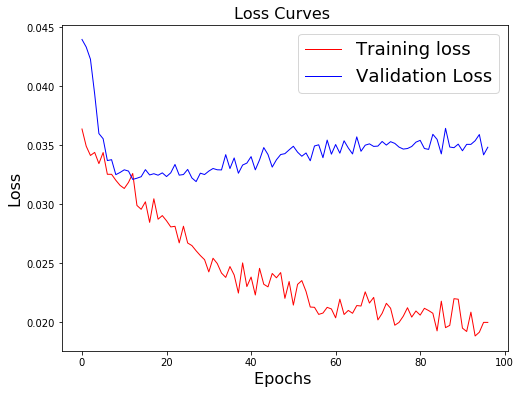

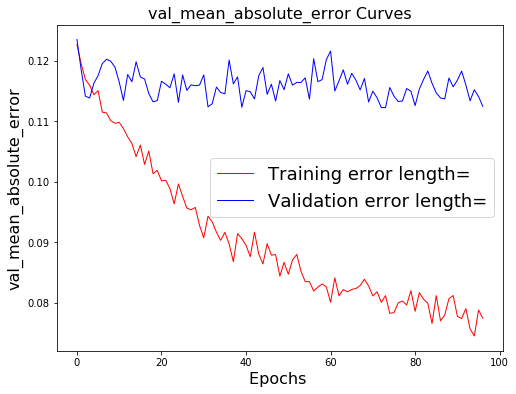

In [9]:
import p7_util
max_length=''
list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

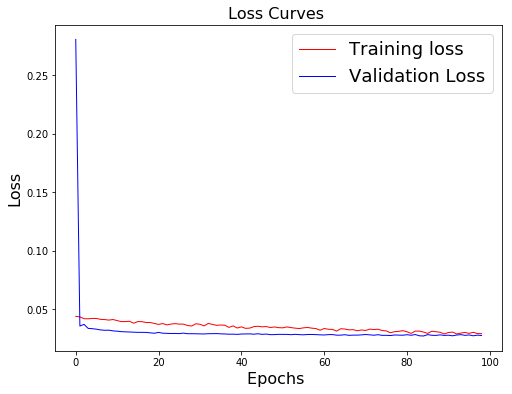

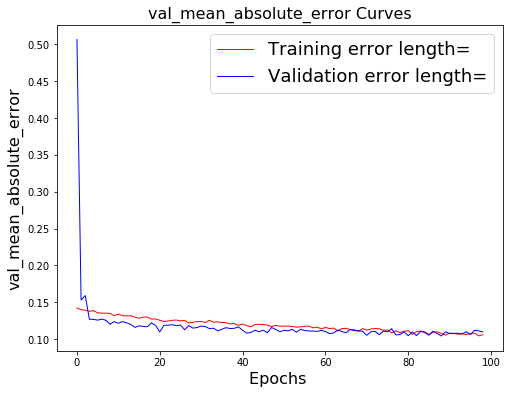

In [5]:
import p7_util
max_length=''
list_model_acc_value = p7_util.p7_plot_cnn_history(model, None, None, history=history, legend='length='+str(max_length))

## <font color=blus>2.3. Words embeddings</font>

## <font color=blus>2.3.1. Building embeddings with Glove</font>

Dictionary `{word:glove_coefficient}` is built from Glove file name.

Glove file has been prealably downloaded.

Once built, dictionary allows to build a vector for every word 
in vocabulary issued from tokenizer.

Using glove file defined here-under, each word is a vector of dimension 100. This dimension is 
referenced in the Glove file name part as `100d`

Endly, weights matrix is built from vocabulary issued from tokenizer. 

Such process is summarized with sequences here-under :
    * dict_glove_word_coeff <-- processing Glove file name
    * vocabulary_word, index <-- tokenizer
    * weight_vector = dict_glove_word_coeff[vocabulary_word]
    * weight_matrix[index] = weight_vector

In [123]:
import numpy as np
import p5_util

filename = './data/embbeding_glove.dump'

weight_matrix = p5_util.object_load(filename)
    
print("")
print("Embedding shape=  {}".format(weight_matrix.shape))


p5_util.object_load : fileName= ./data/embbeding_glove.dump

Embedding shape=  (61834, 100)


In [124]:
import p9_util

embedding_dim=100
dimension = X_train.shape[1]
params = {'dim': (dimension,embedding_dim),
          'batch_size': 100,
          'n_classes': 0,
          'n_channels': 0,
          'shuffle': False}
print(params)

{'dim': (300, 100), 'batch_size': 100, 'n_classes': 0, 'n_channels': 0, 'shuffle': False}


In [125]:
# Data Generators
import DataGenerator
len_train = X_train.shape[0]
train_generator = DataGenerator.DataGenerator(dict_train_partition, dict_train_label, partition_size, len_train,**params)

len_test = X_test.shape[0]
test_generator = DataGenerator.DataGenerator(dict_test_partition, dict_test_label, partition_size,len_test, **params)

In [126]:
filter_size = 9
strides = filter_size-1
nb_filter=128
print("Expected defaut dimension for 1st hidden layer : {}".format(round((vector_dimension-filter_size+2*0)/strides +1)))

Expected defaut dimension for 1st hidden layer : 37


In [127]:
vector_dimension
vocab_size=weight_matrix.shape[0]


In [128]:
import p9_util
embedding_dim=100
model = p9_util.keras_cnn_build((vector_dimension, embedding_dim),nbClasses=1, \
                                strides=strides, nb_filter=nb_filter, filter_size=strides, lr=1.e-2,\
                               isWordEmbedding = True, vocab_size = vocab_size,weight_matrix=weight_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          6183400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 300, 100)          400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 38, 128)           102528    
_________________________________________________________________
flatten_2 (Flatten)          (None, 4864)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 4864)              19456     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                77840     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16)                64        
__________

In [129]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=False,
                    workers=4, verbose=1, epochs=20)

Epoch 1/20
46/46 [==============================] - 8s 165ms/step - loss: 0.0422 - mean_absolute_error: 0.1478 - val_loss: 0.0352 - val_mean_absolute_error: 0.1404
Epoch 2/20
46/46 [==============================] - 5s 103ms/step - loss: 0.0408 - mean_absolute_error: 0.1480 - val_loss: 0.0362 - val_mean_absolute_error: 0.1514
Epoch 3/20
46/46 [==============================] - 5s 104ms/step - loss: 0.0409 - mean_absolute_error: 0.1498 - val_loss: 0.0354 - val_mean_absolute_error: 0.1438
Epoch 4/20
46/46 [==============================] - 5s 104ms/step - loss: 0.0408 - mean_absolute_error: 0.1489 - val_loss: 0.0354 - val_mean_absolute_error: 0.1443
Epoch 5/20
46/46 [==============================] - 5s 105ms/step - loss: 0.0408 - mean_absolute_error: 0.1496 - val_loss: 0.0352 - val_mean_absolute_error: 0.1396
Epoch 6/20
46/46 [==============================] - 5s 110ms/step - loss: 0.0408 - mean_absolute_error: 0.1492 - val_loss: 0.0352 - val_mean_absolute_error: 0.1411
Epoch 7/20
46/46

## <font color=blus>2.3.2. Building embeddings with Scapy</font>

In [138]:
def scapy_weight_matrix_build(spacy_nlp,llist_token_string):
    set_token_string = set()
    index = 0
    
    for list_token_string in llist_token_string :
        for token_string in list_token_string :
            set_token_string.add(token_string)

    vocab_size = len(set_token_string)
    vector_dimension = spacy_nlp.vocab.vectors_length
    weight_matrix = np.zeros((vocab_size, vector_dimension))
    dict_index_tokenstring = dict()
    for token_string, index in zip(set_token_string, range(vocab_size)) :
        if nlp.vocab.has_vector(token_string):
            weight_matrix[index] = nlp.vocab.get_vector(token_string)
            dict_index_tokenstring[index] = token_string
    return weight_matrix,dict_index_tokenstring

In [139]:
import spacy
import p9_util


nlp = p9_util.SPACY_NLP_MD
print(nlp.vocab.length)


1340242


In [140]:
column_name = dataPreparator_train.COLUMN_NAME_TOKEN
llist_token = dataPreparator_train.df_data[column_name].tolist()
spacy_weigth_matrix, dict_index_token = scapy_weight_matrix_build(nlp,llist_token_string)

In [148]:
import p9_util

embedding_dim=300
dimension = spacy_weigth_matrix.shape[1]
params = {'dim': (dimension,embedding_dim),
          'batch_size': 100,
          'n_classes': 0,
          'n_channels': 0,
          'shuffle': False}
print(params)

{'dim': (300, 300), 'batch_size': 100, 'n_classes': 0, 'n_channels': 0, 'shuffle': False}


In [149]:
# Data Generators
import DataGenerator
len_train = X_train.shape[0]
train_generator = DataGenerator.DataGenerator(dict_train_partition, dict_train_label, partition_size, len_train,**params)

len_test = X_test.shape[0]
test_generator = DataGenerator.DataGenerator(dict_test_partition, dict_test_label, partition_size,len_test, **params)

In [150]:
filter_size = 9
strides = filter_size-1
nb_filter=128
print("Expected defaut dimension for 1st hidden layer : {}".format(round((vector_dimension-filter_size+2*0)/strides +1)))

Expected defaut dimension for 1st hidden layer : 37


In [151]:
vector_dimension
vocab_size=weight_matrix.shape[0]
vector_dimension,vocab_size,embedding_dim

(300, 61834, 300)

In [152]:
import p9_util
embedding_dim=100
model = p9_util.keras_cnn_build((vector_dimension, embedding_dim),nbClasses=1, \
                                strides=strides, nb_filter=nb_filter, filter_size=strides, lr=1.e-2,\
                               isWordEmbedding = True, vocab_size = vocab_size,weight_matrix=weight_matrix)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          6183400   
_________________________________________________________________
batch_normalization_21 (Batc (None, 300, 100)          400       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 38, 128)           102528    
_________________________________________________________________
flatten_5 (Flatten)          (None, 4864)              0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 4864)              19456     
_________________________________________________________________
dense_17 (Dense)             (None, 16)                77840     
_________________________________________________________________
batch_normalization_23 (Batc (None, 16)                64        
__________

In [153]:
# Train model on dataset
history = model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                    use_multiprocessing=False,
                    workers=4, verbose=1, epochs=20)

Epoch 1/20
46/46 [==============================] - 8s 183ms/step - loss: 0.0414 - mean_absolute_error: 0.1469 - val_loss: 0.0352 - val_mean_absolute_error: 0.1399
Epoch 2/20
46/46 [==============================] - 5s 103ms/step - loss: 0.0408 - mean_absolute_error: 0.1491 - val_loss: 0.0352 - val_mean_absolute_error: 0.1395
Epoch 3/20
46/46 [==============================] - 5s 105ms/step - loss: 0.0409 - mean_absolute_error: 0.1487 - val_loss: 0.0362 - val_mean_absolute_error: 0.1512
Epoch 4/20
46/46 [==============================] - 5s 104ms/step - loss: 0.0409 - mean_absolute_error: 0.1491 - val_loss: 0.0362 - val_mean_absolute_error: 0.1515
Epoch 5/20
46/46 [==============================] - 5s 106ms/step - loss: 0.0409 - mean_absolute_error: 0.1493 - val_loss: 0.0353 - val_mean_absolute_error: 0.1420
Epoch 6/20
46/46 [==============================] - 5s 106ms/step - loss: 0.0409 - mean_absolute_error: 0.1498 - val_loss: 0.0352 - val_mean_absolute_error: 0.1362
Epoch 7/20
46/46